# Ejercicio Final
## La tarea consiste en resolver un challenge de Machine Learning, Diabetes Prediction, en equipo aplicando los conocimientos adquiridos en el módulo de Aprendizaje Supervisado y No Supervisado, así como los modelos descritos en el documento MLpedia.
## El challenge simula un caso real de Data Science, donde no existe una única solución correcta, sino decisiones justificadas en base a datos, métricas y criterios técnicos

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import LabelEncoder, label_binarize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
df = pd.read_csv('train.csv', sep=';')
df.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


Se trata de un dataset con etiquetas, por lo que será Aprendizaje Supervisado

In [5]:
#2- Exploración y Preprocesamiento
print("\nInformación del dataset:")
print(df.info())

#2.1 Valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

#Descripción
print("\nDescripción estadística:")
print(df.describe())



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                                            Non-Null Count   Dtype 
---  ------                                                                                                                                                                                                                                                                                                                                                                                                                      

In [10]:
#2.2 Correlación de las variables
correlation_matrix = df.corr(numeric_only=True)
print("\nMatriz de correlación:")
print(correlation_matrix)


Matriz de correlación:
                                          id       age  \
id                                  1.000000  0.001615   
age                                 0.001615  1.000000   
alcohol_consumption_per_week        0.001614  0.003295   
physical_activity_minutes_per_week  0.012424 -0.029101   
diet_score                          0.000878 -0.001898   
sleep_hours_per_day                -0.002118 -0.001286   
screen_time_hours_per_day          -0.000716 -0.002313   
bmi                                -0.000692  0.062958   
waist_to_hip_ratio                 -0.000144  0.044654   
systolic_bp                         0.001546  0.502894   
diastolic_bp                       -0.000234  0.188403   
heart_rate                         -0.000764  0.004294   
cholesterol_total                   0.000518  0.283155   
hdl_cholesterol                    -0.000368  0.002654   
ldl_cholesterol                     0.000129  0.245503   
triglycerides                       0.001865  0.

In [19]:
from sklearn.preprocessing import StandardScaler

#3- Selección de variables y división del Dataset

# Creamos objetivo binario desde num; num=0 significa no hay efermedad
# y si es mayor es que la puede haber
df['target'] = (df['diagnosed_diabetes'] > 0).astype(int)

#Definir la Y como las variables objetivo
y = df['target'] # Use the newly created target

# Definir X como las características numéricas, excluyendo el target y columnas no útiles
X = df.drop(['target', 'diagnosed_diabetes', 'id'], axis=1)

# Codificación de la variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Binarización para ROC multiclase
y = label_binarize(y_encoded, classes=np.unique(y_encoded))
n_classes = y.shape[1]

# Dividir los datos para entrenar 80% y probar 20%, asegurando la estratificación por la variable objetivo
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTamaños:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

# Codificar variables categóricas
categorical_cols = ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']
for col in categorical_cols:
    le_col = LabelEncoder()
    X_train[col] = le_col.fit_transform(X_train[col])
    X_test[col] = le_col.transform(X_test[col])

# Escalar solo las características de X una vez definidas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Tamaños:
X_train: (560000, 24)
X_test : (140000, 24)
y_train: (560000, 1)
y_test : (140000, 1)


Entrenamiento del Modelo: Utiliza la regresión logística para entrenar un modelo con el conjunto de entrenamiento.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV

#Inicializo el modelo con Regresión logística
model = LogisticRegression(solver='liblinear', random_state=42)

params = {'fit_intercept': [True, False]}

# Use an appropriate scoring metric for classification, e.g., f1_score
# Reduced cv to 3 to mitigate single-class issues in folds due to class imbalance
# Added error_score='raise' to get a more detailed traceback for fit failures
grid_search = GridSearchCV(model, params, cv=3, scoring=make_scorer(f1_score), error_score='raise')
grid_search.fit(X_train, y_train)
# Mejor modelo
best_model = grid_search.best_estimator_

# Set 'model' to the best model found by GridSearchCV for subsequent use
model = best_model

c:\Users\seje\AppData\Local\anaconda3\envs\Jesuspython\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\seje\AppData\Local\anaconda3\envs\Jesuspython\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\seje\AppData\Local\anaconda3\envs\Jesuspython\Lib\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\seje\AppData\Local\anaconda3\envs\Jesuspython\Lib\site-packages\sklearn\utils\validation.py:1352: DataC

In [21]:
#Obtengo los resultados para cada uno de los funciones de regresión
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = model.predict(X_test)

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 0.6636
Precision: 0.6811
Recall: 0.8655
F1-Score: 0.7623
AUC-ROC: 0.6944


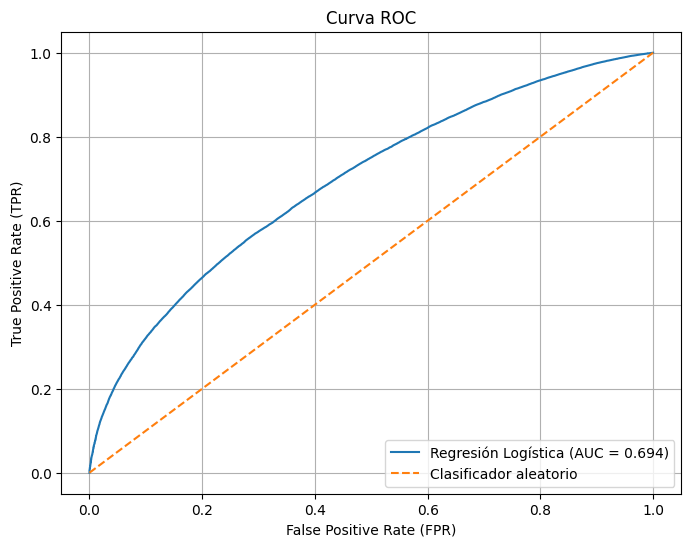

In [23]:
#Dibujamos la curva ROC para ver nuestra regresión logística para clasificar el dataset

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Regresión Logística (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Clasificador aleatorio")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()